#### Normalizing Flows

In [10]:
%pylab inline
from vae_nf import *

Populating the interactive namespace from numpy and matplotlib


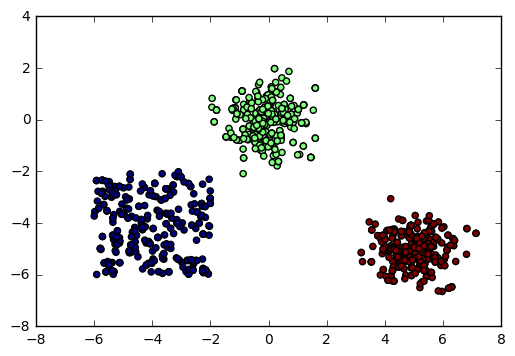

In [2]:
N = 1000
xs = np.vstack((
    np.random.uniform(-6, -2, size=(N/3, 2)),
    np.random.multivariate_normal([0, 0], np.eye(2)/2, size=N/3),
    np.random.multivariate_normal([5, -5], np.eye(2)/2, size=N/3)
))
ys = np.repeat(np.arange(3), N/3)


idxs = np.random.choice(range(xs.shape[0]), xs.shape[0])
xs, ys = xs[idxs], ys[idxs]

plt.scatter(xs[:, 0], xs[:, 1], c=ys);

In [4]:
tf.reset_default_graph()

data = xs
data_dim = xs.shape[1]

enc_h = 128
enc_z = 2
dec_h = 128
max_iters = 10000
batch_size = data.shape[0]
learning_rate = 0.001
k = 3

x, e = inputs(data_dim, enc_z)
mu, log_var, z0, lambd = encoder(x, e, data_dim, enc_h, enc_z, k)
z_k, log_detj = norm_flow(z0, lambd, k, enc_z)
out_op, out_mu, out_log_var = decoder(z_k, data_dim, dec_h, enc_z, out_fn=tf.identity)
loss_op = make_loss(out_op, x, log_var, mu, log_detj, z0)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

idx = 0
for i in xrange(max_iters):
    x_ = data[idx:idx+batch_size]
    l = train_step(sess, x_, train_op, loss_op, x, e, enc_z)
    idx += batch_size
    if idx >= x_.shape[0]:
        idx = 0
    if i % 1000 == 0:
        print('iter: %d\tloss: %.2f' % (i, l))

iter: 0	loss: 9943.61
iter: 1000	loss: 119.90
iter: 2000	loss: 78.17
iter: 3000	loss: 62.74
iter: 4000	loss: 59.41
iter: 5000	loss: 45.29
iter: 6000	loss: 57.33
iter: 7000	loss: 51.12
iter: 8000	loss: 46.85
iter: 9000	loss: 41.32


In [5]:
def sample_latent(sess, input_data, z_op, x_op, e_op, Z):
    e_ = np.random.normal(size=(input_data.shape[0], Z))
    zs = sess.run(z_op, feed_dict={x_op: input_data, e_op: e_})
    return zs

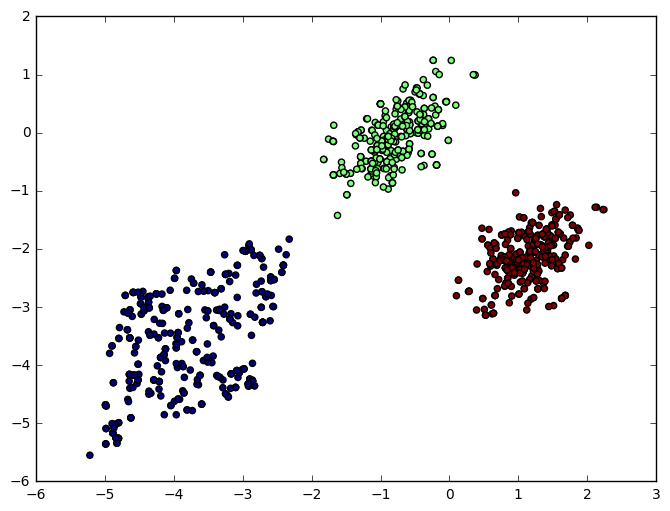

In [6]:
zs = sample_latent(sess, xs, z_k, x, e, enc_z)
fig = plt.figure(figsize=(8, 6));
plt.scatter(zs[:, 0], zs[:, 1], c=ys)
plt.show();

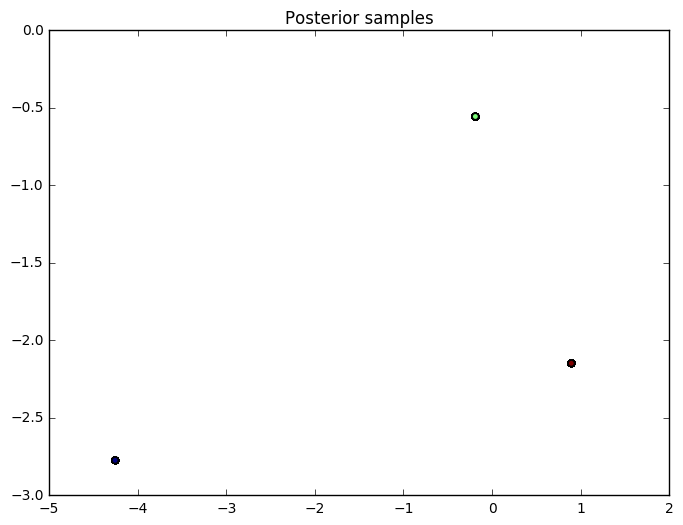

In [7]:
k = 500

# Take a data point from each class
x_ = np.repeat(data[[(ys==i).argmax() for i in range(3)]], k, axis=0)
y_ = np.repeat(np.arange(3), k)
e_ = np.random.normal(size=(x_.shape[0], enc_z))
zs = sess.run(z_k, feed_dict={x: x_, e: e_})

fig = plt.figure(figsize=(8, 6));
plt.scatter(zs[:, 0], zs[:, 1], c=y_)
plt.title("Posterior samples")
plt.show();

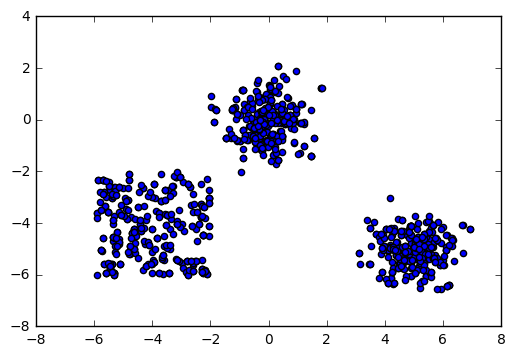

In [8]:
reconstructed = reconstruct(sess, data, out_op, x, e, enc_z)[0]
plt.scatter(reconstructed[:, 0], reconstructed[:, 1])